In [1]:
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.windows import from_bounds
from rasterio.plot import show
from shapely.geometry import shape
import numpy as np

import requests

### DHX Admin boundaries

In [2]:
def get_admin_Path(amdin=2):
    """
    amdin (int): 0-3
    """
    return f"../data/lbn_adm_cdr_20200810/lbn_admbnda_adm{amdin}_cdr_20200810.shp"

In [3]:
shp_file_path = get_admin_Path()
shp_file_path

'../data/lbn_adm_cdr_20200810/lbn_admbnda_adm2_cdr_20200810.shp'

In [4]:
gdf = gpd.read_file(shp_file_path)

In [5]:
len(gdf)

26

In [6]:
gdf.head()

,OBJECTID_1,OBJECTID,admin2Name,admin2Na_1,admin2Pcod,admin2RefN,admin2AltN,admin2Al_1,admin2Al_2,admin2Al_3,...,admin0Name,admin0Na_1,admin0Pcod,date,validOn,ValidTo,Shape_Leng,Shape_Le_1,Shape_Area,geometry
0,1,1,Akkar,عكار,LB51,None,None,None,None,None,...,Lebanon,لبنان,LB,2015-11-06,2016-08-22,0000/00/00,1.814552,1.814552,0.077486,"POLYGON ((36.33531 34.69206, 36.33624 34.69186..."
1,2,2,El Hermel,الهرمل,LB22,None,None,None,None,None,...,Lebanon,لبنان,LB,2015-11-06,2016-08-22,0000/00/00,1.340073,1.340073,0.051881,"POLYGON ((36.33386 34.51858, 36.33377 34.5184,..."
2,3,3,El Minieh-Dennie,المنية الضنية,LB55,None,None,None,None,None,...,Lebanon,لبنان,LB,2015-11-06,2016-08-22,0000/00/00,1.386036,1.386036,0.035508,"POLYGON ((35.95907 34.50974, 35.96099 34.50909..."
3,4,4,Tripoli,طرابلس,LB56,None,None,None,None,None,...,Lebanon,لبنان,LB,2015-11-06,2016-08-22,0000/00/00,0.511835,0.511835,0.002670,"MULTIPOLYGON (((35.80286 34.39852, 35.80318 34..."
4,5,5,Zgharta,زغرتا,LB57,None,None,None,None,None,...,Lebanon,لبنان,LB,2015-11-06,2016-08-22,0000/00/00,1.017069,1.017069,0.017383,"POLYGON ((35.93039 34.45684, 35.93055 34.45608..."


In [7]:
# fill population with random data
gdf["population"] = np.random.randint(10000, 456789, gdf.shape[0])

In [8]:
json_gdf = gdf[["admin2Name", "admin2Na_1", "admin2Pcod", "date", "validOn", "population", "geometry"]]
json_gdf.head()

,admin2Name,admin2Na_1,admin2Pcod,date,validOn,population,geometry
0,Akkar,عكار,LB51,2015-11-06,2016-08-22,283190,"POLYGON ((36.33531 34.69206, 36.33624 34.69186..."
1,El Hermel,الهرمل,LB22,2015-11-06,2016-08-22,57306,"POLYGON ((36.33386 34.51858, 36.33377 34.5184,..."
2,El Minieh-Dennie,المنية الضنية,LB55,2015-11-06,2016-08-22,401686,"POLYGON ((35.95907 34.50974, 35.96099 34.50909..."
3,Tripoli,طرابلس,LB56,2015-11-06,2016-08-22,96645,"MULTIPOLYGON (((35.80286 34.39852, 35.80318 34..."
4,Zgharta,زغرتا,LB57,2015-11-06,2016-08-22,80480,"POLYGON ((35.93039 34.45684, 35.93055 34.45608..."


In [9]:
csv_df = pd.DataFrame(gdf[["admin2Name", "admin2Na_1", "admin2Pcod", "date", "validOn","population"]])
csv_df.head()

,admin2Name,admin2Na_1,admin2Pcod,date,validOn,population
0,Akkar,عكار,LB51,2015-11-06,2016-08-22,283190
1,El Hermel,الهرمل,LB22,2015-11-06,2016-08-22,57306
2,El Minieh-Dennie,المنية الضنية,LB55,2015-11-06,2016-08-22,401686
3,Tripoli,طرابلس,LB56,2015-11-06,2016-08-22,96645
4,Zgharta,زغرتا,LB57,2015-11-06,2016-08-22,80480


In [10]:
# json_gdf.to_file("../data/lebanon-draft-01.json", driver="GeoJSON")
# csv_df.to_csv("../data/lebanon-draft-01.csv")

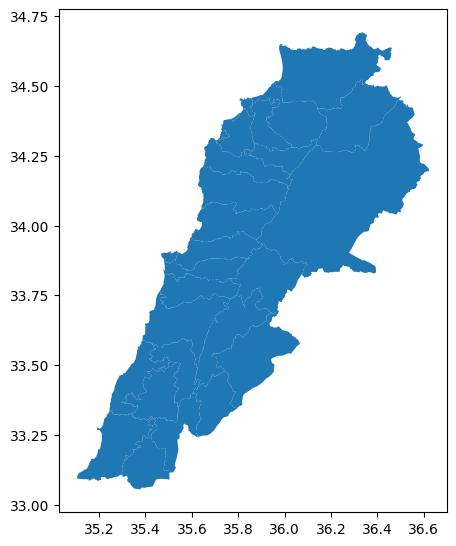

In [11]:
gdf["geometry"].plot(figsize=(5,7));

### Flood data

In [12]:
def load_raster_subset(raster_path, polygon_geometry):
    with rio.open(raster_path) as src:
        # Get the bounds of the polygon
        minx, miny, maxx, maxy = polygon_geometry.bounds
        
        # Create a window from the polygon bounds
        window = from_bounds(minx, miny, maxx, maxy, src.transform)
        
        # Read the data in the window
        out_image = src.read(window=window)
        
        # Get the transform for the window
        out_transform = src.window_transform(window)
        
        # Update the metadata
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
    
    return out_image, out_meta

In [13]:
from shapely.ops import unary_union

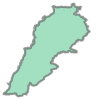

In [14]:
lebanon_shp = unary_union(gdf["geometry"])
lebanon_shp

In [15]:
img, meta = load_raster_subset(
    "../data/flood/floodMapGL_rp100y.tif",
    lebanon_shp
)

In [16]:
img[0].shape

(196, 182)

In [17]:
from matplotlib import pyplot as plt

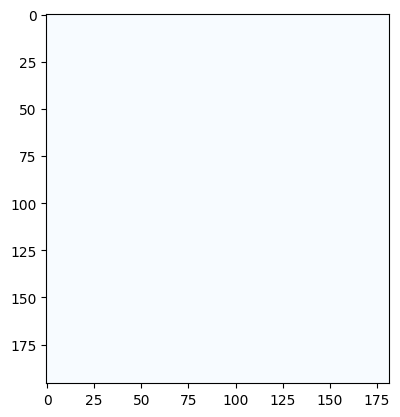

In [18]:
show(img[0], cmap='Blues');

In [19]:
meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028230607370965e+38,
 'width': 182,
 'height': 196,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.008333333333333, 0.0, np.float64(35.103487365585096),
        0.0, -0.008333333333333, np.float64(34.692069153709994))}